# Physics 240 - Assignment 3

# Ramon Ciutad Perez

This code must be read along with the handwritten notebook, which includes all formulas used here and their derivations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as so
import scipy.stats as ss
from astropy.io import fits

## Problem 1 : Gaussian Process Regression to Fix Images

# 1) a)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 4.000e+00,
        6.000e+00, 7.000e+00, 3.000e+00, 3.000e+00, 6.000e+00, 8.000e+00,
        1.000e+01, 1.100e+01, 1.400e+01, 1.500e+01, 1.800e+01, 1.700e+01,
        2.700e+01, 5.100e+01, 6.800e+01, 7.600e+01, 1.270e+02, 2.090e+02,
        4.180e+02, 1.241e+03, 3.722e+03, 2.276e+03, 7.700e+02, 2.960e+02,
        1.770e+02, 1.020e+02, 8.100e+0

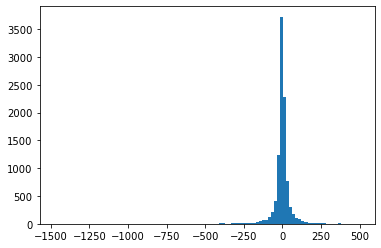

In [2]:
# Problem 1 part a

images = fits.open("Images for Homework 4, Part 1.fits")[0].data

iterations = 10000

indices_1 = np.random.randint(1, len(images[:,0,0]) - 1, iterations)
indices_2 = np.random.randint(1, len(images[0,:,0]) - 1, iterations)
indices_3 = np.random.randint(1, len(images[0,0,:]) - 1, iterations)

pixels = images[indices_1, indices_2, indices_3]
median_differences = []

for i in range(iterations):
    neighbors_pixels = []
    indices_range_2 = [indices_2[i] - 1, indices_2[i], indices_2[i] + 1]
    indices_range_3 = [indices_3[i] - 1, indices_3[i], indices_3[i] + 1]
    pixel = images[indices_1[i], indices_2[i], indices_3[i]]
    
    for j in indices_range_2:
        for k in indices_range_3:
            if [j,k] != [indices_2[i], indices_3[i]]:
                neighbors_pixels.append(images[indices_1, j, k])
    
    median = np.median(neighbors_pixels)
    difference = median - pixel
    median_differences.append(difference)

plt.hist(median_differences, bins=100)    

# 1) b)

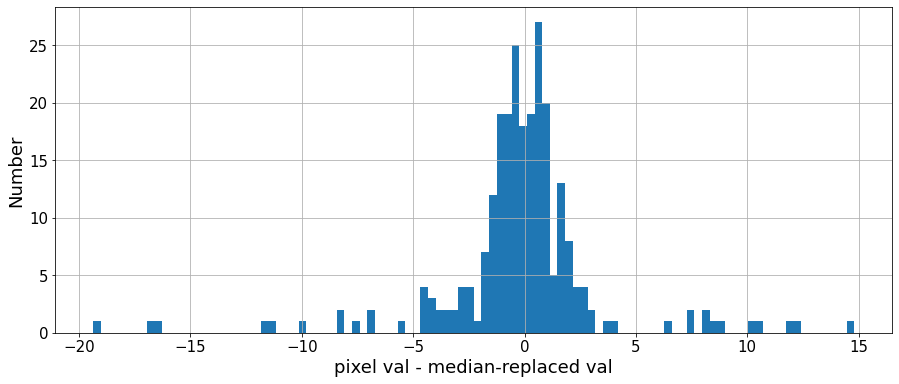

CPU times: user 34.5 s, sys: 1min 6s, total: 1min 40s
Wall time: 50.9 s


In [3]:
%%time

def plot_differences(differences_trial):
    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(111)
    ax.hist(differences_trial, bins=100)
    ax.set_xlabel('pixel val - median-replaced val', fontsize=18)
    ax.set_ylabel('Number', fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True)
    plt.show()

def k_func(a, h, coord_1, coord_2):

    diff2 = (coord_2[1] - coord_1[1])**2 + (coord_2[0] - coord_1[0])**2

    return a**2 * np.exp(- diff2 / (2 * h**2))

mean_image = np.mean(images, axis=0)
images_mean_sub = images - mean_image

def find_matrices(x, y, a, h, image):

    k_yx = np.array([])
    f_x = np.array([])
    coord_list = []

    for i in range(-4, 5):
        for j in range(-4, 5):

            if i == 0 and j == 0:
                continue

            temp_ky = k_func(a, h, [y, x], [y+i, x+j])
            k_yx = np.append(k_yx, temp_ky)

            f_x = np.append(f_x, image[y, x])

            coord_list.append([y+i, x+j])

    k_xy = k_yx.T

    k_yy = k_func(a, h, [y, x], [y, x])

    k_xx = np.empty((0, 9**2-1))

    for coord in coord_list:
        temp_arr = np.array([])
        for i in range(-4, 5):
            for j in range(-4, 5):
                if i == 0 and j == 0:
                    continue
                temp_val = k_func(a, h, coord, [y+i, x+j])
                temp_arr = np.append(temp_arr, temp_val)
        k_xx = np.vstack((k_xx, temp_arr))

    data_sigma = 5
    cov_data = np.identity(len(k_xx)) * data_sigma**2

    return k_xx + cov_data, k_xy, k_yx, k_yy, f_x

no_trials = 250
a_trial = 5
h_trial = 5

x_trials = []
y_trials = []
image_trials = []
for _ in range(no_trials):
    image_trial = images_mean_sub[np.random.randint(0, len(images))]
    y_trial = np.random.randint(4, len(image_trial)-4)
    x_trial = np.random.randint(4, len(image_trial[0])-4)

    image_trials.append(image_trial)
    x_trials.append(x_trial)
    y_trials.append(y_trial)

def find_differences(a, h, x_tests, y_tests, image_tests):

    differences_list = []
    for index, image in enumerate(image_tests):

        k_xx_full, k_xy, k_yx, k_yy, f_x = find_matrices(x_tests[index], y_tests[index], a, h, image)

        mu = np.dot( k_yx, np.dot(np.linalg.inv(k_xx_full), f_x) )
        err = k_yy - np.dot( k_yx, np.dot(np.linalg.inv(k_xx_full), k_xy) )

        difference_trial = image[y_tests[index], x_tests[index]] - mu
        differences_list.append(difference_trial)

    return differences_list

differences = find_differences(a_trial, h_trial, x_trials, y_trials, image_trials)
plot_differences(differences)

# 1) c)

In [ ]:
def find_sample_std(params, x_tests, y_tests, image_tests):

    differences_list = find_differences(params[0], params[1], x_tests, y_tests, image_tests)

    differences_mean = np.mean(differences_list)
    differences_std = np.std(differences_list)

    if abs(differences_std) <= 0.1:
        differences_std = 0

    return differences_std

best_params = so.minimize(find_sample_std, np.array([5, 5]), args=(x_trials, y_trials, image_trials), options={10}).x
print(best_params)

## Problem 2 : A Mixture Model and Bootstrapping, Redux

# 2) a)

This part is done entirely in the handwritten noteboook.

# 2) b)

In [5]:
# Problem 2 part b)
data = np.genfromtxt('Velocities for Homework 4, Part 2.dat', comments='#')

xdot_1 = data[:,0]
xdot_error_1 = data[:,1]
xdot_2 = data[:,4]
xdot_error_2 = data[:,5]
ydot_1 = data[:,2]
ydot_error_1 = data[:,3]
ydot_2 = data[:,6]
ydot_error_2 = data[:,7]

difference_xdot_data = xdot_1 - xdot_2
difference_ydot_data = ydot_1 - ydot_2
variance_xdot_data = xdot_error_1**2 + xdot_error_2**2
variance_ydot_data = ydot_error_1**2 + ydot_error_2**2

def find_log_likelihood(parameters, difference_xdot=difference_xdot_data,
                        difference_ydot=difference_ydot_data,
                        variance_xdot=variance_xdot_data,
                        variance_ydot=variance_ydot_data):
    delta_xdot, delta_ydot, a, b, g = parameters
    
    # Start finding the likelihood in the good case:
    sigma_x = (a**2 * variance_xdot + b**2)
    sigma_y = (a**2 * variance_ydot + b**2)
    factor = 1 / (2*np.pi * np.sqrt(sigma_x * sigma_y))
    exponent = -1/2 * ((difference_xdot - delta_xdot)**2 / sigma_x + (difference_ydot - delta_ydot)**2 / sigma_y)
    likelihood_good = factor * np.exp(exponent)
    
    # Now the likelihood for the bad case:
    exponent = -1/2 * ((difference_xdot - delta_xdot)**2 / 4 + (difference_ydot - delta_ydot)**2 / 4)
    likelihood_bad = 1/(8*np.pi) * np.exp(exponent)
    
    total_likelihood = g * likelihood_good + (1-g) * likelihood_bad
    log_L = np.sum(np.log(total_likelihood))
    
    return -log_L

params = so.differential_evolution(find_log_likelihood, [(-0.5, 0.5), (-0.5, 0.5), (0, 5), (0, 1), (0, 1)]).x
#params = so.minimize(find_log_likelihood, [0.1, -0.1, 0.5, 0.5, 0.5], method='Nelder-Mead').x

print(params)

[ 0.08272071 -0.14993113  1.37454603  0.05209836  0.80239219]


# 2) c)

In [6]:
# Problem 2 part c)
# Use bootstrap to find errors on the best fit parameters
n_iterations = 100
params_array = np.empty((0, 5))
print()
for sample in range(n_iterations):
    indices_sample = np.random.randint(0, len(xdot_1), len(xdot_1))
    indices_sample = np.array(sorted(list(indices_sample)))
    difference_xdot_sample = difference_xdot_data[indices_sample]
    difference_ydot_sample = difference_ydot_data[indices_sample]
    variance_xdot_sample = variance_xdot_data[indices_sample]
    variance_ydot_sample = variance_ydot_data[indices_sample]
    # params_sample = so.differential_evolution(find_log_likelihood, [(-0.5, 0.5), (-0.5, 0.5), (0, 5), (0, 1), (0, 1)],
    #                                           args=(difference_xdot_sample, difference_ydot_sample, variance_xdot_sample, variance_ydot_sample)).x
    params_sample = so.minimize(find_log_likelihood, [0.1, -0.1, 0.5, 0.5, 0.5], method='Nelder-Mead',
                                args=(difference_xdot_sample, difference_ydot_sample, variance_xdot_sample, variance_ydot_sample)).x
    # params_sample = np.reshape(params_sample, (1, 5))
    params_array = np.vstack((params_array, params_sample))

errors_params = np.std(params_array, axis=0)
print(errors_params)


[0.00715785 0.0082336  0.17462089 0.03142246 0.02357776]


In [7]:
print('The optimal delta-xdot is: {0:.4f} ± {1:.4f}'.format(params[0], errors_params[0]))
print('The optimal delta-ydot is: {0:.4f} ± {1:.4f}'.format(params[1], errors_params[1]))
print('The optimal fit parameter a is: {0:.4f} ± {1:.4f}'.format(params[2], errors_params[2]))
print('The optimal fit parameter b is: {0:.4f} ± {1:.4f}'.format(params[3], errors_params[3]))
print('The optmal prior probability g is: {0:.4f} ± {1:.4f}'.format(params[4], errors_params[4]))

The optimal delta-xdot is: 0.0827 ± 0.0072
The optimal delta-ydot is: -0.1499 ± 0.0082
The optimal fit parameter a is: 1.3745 ± 0.1746
The optimal fit parameter b is: 0.0521 ± 0.0314
The optmal prior probability g is: 0.8024 ± 0.0236


## Problem 3 : Measure your Evidence, Watch your Assumptions

This problem is mostly solved and discussed in the hadwritten notebook, and only a few calculations are computed here.

In [8]:
delta_AIC = -2.61
delta_BIC = -1.66

strength_AIC = np.exp(delta_AIC)
print('The strength of the evidence of the black hole using the AIC is: {:.4f}'.format(strength_AIC))
n_sigma_AIC = ss.norm.isf(strength_AIC)
print(r'This corresponds to {:.2f} Gaussian standard deviations'.format(n_sigma_AIC))

strength_BIC = np.exp(delta_BIC)
print('\nThe strength of the evidence of the black hole using the BIC is: {:.4f}'.format(strength_BIC))
n_sigma_BIC = ss.norm.isf(strength_BIC)
print(r'This corresponds to {:.2f} Gaussian standard deviations'.format(n_sigma_BIC))

The strength of the evidence of the black hole using the AIC is: 0.0735
This corresponds to 1.45 Gaussian standard deviations

The strength of the evidence of the black hole using the BIC is: 0.1901
This corresponds to 0.88 Gaussian standard deviations
